In [1]:
%matplotlib widget
%load_ext line_profiler
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import csv
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from collections import namedtuple

from sfdata import SFDataFile, SFDataFiles
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *

import warnings
warnings.filterwarnings('ignore')

## Test static data (BSREAD, BSDATA, CAMERA and JF)

In [2]:
ff = "/sf/alvra/data/p19636/raw/run0046/data/acq0071.*.h5"

fnames = SFDataFiles(ff)

channels = [channel_diode_1]

results,_ = load_data_compact(channels, fnames)

print (results[channel_diode_1].shape)
    


--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet  2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET 2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 2001 / 2001 -> 0% loss
complete channels: 2 / 2 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
(2001,)


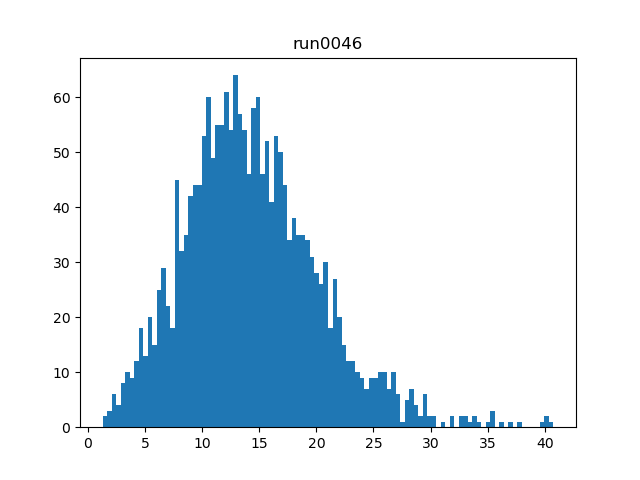

Avg fluo is 14.358692797660854


In [7]:
fluo = results[channel_diode_1]
plt.figure()
plt.title(ff.split('/')[-3])
plt.hist(fluo, bins = 100)
plt.show()
print ('Avg fluo is {}'.format(np.mean(fluo)))

## Test FEL pump / laser probe (YAG scans)

In [22]:
bsread_file = "/sf/alvra/data/p17589/raw/2020-07-02_YAG_timing_9/run_000451.BSREAD.h5"

channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode]
channel_list_all = channel_list_pp + [channel_Izero122, channel_delay_harm]

results_pp, results_FEL, FEL_reprate, ratio = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, bsread_file)

print (results_pp[channel_LaserDiode].pump.shape,
       results_pp[channel_LaserDiode].unpump.shape,
       results_FEL[channel_Izero122].shape,
       results_FEL[channel_delay_harm].shape)

Probe rep rate (laser) is 100.0 Hz
Pump rep rate (FEL) is 50.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       10001 / 10001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH1_BUFFER    5000 / 10001 -> 50% loss ▇▇▇▇▇
SAROP11-PALMK118:CH2_BUFFER    5000 / 10001 -> 50% loss ▇▇▇▇▇
SAROP11-PBPS122:INTENSITY      5000 / 10001 -> 50% loss ▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS    10001 / 10001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 10000 / 10001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 10000 / 10001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 5000 / 10001 -> 50% loss

--------------------------------------------------------------------------------

(4999,) (4999,) (4999,) (4999, 2000) (4999,)


## Test laser pump / FEL probe (different pumping schemes)

In [18]:
#bsread_file = "/sf/alvra/data/p17589/raw/laserPump4t1/run_001197.BSREAD.h5"
#bsread_file = "/sf/alvra/data/p17589/raw/laserPump11t1/run_001195.BSREAD.h5"run_034923
ff = "/sf/alvra/data/p19198/raw/s4_Au_50nm_2/run_000896.BSDATA.h5"
#bsread_file = "/sf/alvra/data/p17589/raw/laserPump1t1/run_001202.BSREAD.h5"

fnames = SFDataFiles(ff)

channel_list_pp = [channel_Events, channel_Izero117, channel_APD_Ch1]
channel_list_all = channel_list_pp + [channel_delay_harm]


results_pp, results_FEL, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, fnames)

print (#results_pp['SAROP11-CVME-PBPS2:Lnk9Ch13-DATA-SUM/data'].pump.shape,
       #results_pp['SAROP11-CVME-PBPS2:Lnk9Ch13-DATA-SUM/data'].unpump.shape,
       results_pp[channel_Izero117].pump.shape,
       results_pp[channel_Izero117].unpump.shape,
       results_pp[channel_APD_Ch1].pump.shape,
       results_pp[channel_APD_Ch1].unpump.shape)


--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet    1000 / 1000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET   1000 / 1000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY   978 / 1000 -> 2% loss ▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS 1000 / 1000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 978 / 1000 -> 2% loss
complete channels: 3 / 4 -> 25% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 6:1
Loaded 839 pump and 139 unpump shots
(839,) (139,) (839,) (139,)


## Test data

## Function for FEL pump / laser probe (as in alvra_tools/load_data.py)

In [37]:
#bsread_file = "/sf/alvra/data/p17589/raw/scan_data/scan0010_2020-07-03-SiN4_5/scan0010_2020-07-03-SiN4_5_step0047/run_001149.BSREAD.h5"
#bsread_file = "/sf/alvra/data/p17589/raw/scan_data/scan0010_2020-07-03-SiN4_5/scan0010_2020-07-03-SiN4_5_step0000/run_001102.BSREAD.h5"
bsread_file = "/sf/alvra/data/p17589/raw/scan_data/scan0010_2020-07-03-SiN4_5/scan0010_2020-07-03-SiN4_5_step0019/run_001121.BSREAD.h5"

channels_always = [channel_Events, channel_LaserDiode, channel_Laser_refDiode]
channels_pump   = channels_always + [channel_Izero122, channel_delay_harm, channel_PALM_streak]
channels_unpump = channels_always

with SFDataFiles(bsread_file) as data:
    subset_unpump = data[channels_unpump]
    #subset_unpump.print_stats(show_complete=True)
    subset_unpump.drop_missing()

    event_code = subset_unpump[channel_Events].data

    ec_FEL      = event_code[:, 12] # Event 12: BAM bunch 1
    ec_Laser    = event_code[:, 18]
    ec_Darkshot = event_code[:, 21]

    index_dark_before = np.append([True], np.logical_not(ec_Darkshot))[:-1]
    index_light = np.logical_and.reduce((ec_FEL, ec_Laser, np.logical_not(ec_Darkshot), index_dark_before))
    index_dark  = np.logical_and.reduce((np.logical_not(ec_FEL), ec_Laser, np.logical_not(ec_Darkshot), index_dark_before))

    result_unpump = {}
    for ch in channels_unpump:
        try:
            result_unpump[ch] = subset_unpump[ch].data[index_dark] # these are still all shots, thus we ignore the pump shots here!
        except Exception as e:
            print("channel missing:", ch, e)

    actual_pids_unpump = subset_unpump[channel_Events].pids[index_dark]

with SFDataFiles(bsread_file) as data:
        
    subset_pump = data[channels_pump]
    subset_pump.print_stats(show_complete=True)
    subset_pump.drop_missing()
        
    result_pump = {}
    for ch in channels_pump:
        try:
            result_pump[ch] = subset_pump[ch].data
        except Exception as e:
            print ("Channel missing:", ch, e)
        
    actual_pids_pump = subset_pump[channel_Events].pids

#wanted_pids_pump  = actual_pids_unpump + 1
#final_pids, ind_pump, ind_unpump = np.intersect1d(actual_pids_pump, wanted_pids_pump, return_indices=True)
#_, _, ind_unpump = np.intersect1d(final_pids, actual_pids_unpump, return_indices=True)

wanted_pids_pump  = actual_pids_unpump + 1
final_pids_pump, ind_pump, _ind_unpump = np.intersect1d(actual_pids_pump, wanted_pids_pump, return_indices=True)
final_pids_unpump = final_pids_pump - 1
_, _, ind_unpump = np.intersect1d(final_pids_unpump, actual_pids_unpump, return_indices=True)

for ch in channels_pump:
    result_pump[ch] = result_pump[ch][ind_pump]

for ch in channels_unpump:
    result_unpump[ch] = result_unpump[ch][ind_unpump]


ppdata = namedtuple("PPData", ["pump", "unpump"])

result_pp = {}
shared_channels = set(channels_pump).intersection(channels_unpump)
for ch in shared_channels:
     result_pp[ch] = ppdata(pump=result_pump[ch], unpump= result_unpump[ch])

print (result_pp[channel_LaserDiode].pump.shape,
       result_pp[channel_LaserDiode].unpump.shape,
       result_pump[channel_PALM_streak].shape,
       result_pump[channel_Izero122].shape,
       result_pump[channel_delay_harm].shape)



--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet       3001 / 3001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PALMK118:CH2_BUFFER   1501 / 3001 -> 50% loss ▇▇▇▇▇
SAROP11-PBPS122:INTENSITY     1500 / 3001 -> 50% loss ▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS    2999 / 3001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 3001 / 3001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 3001 / 3001 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1498 / 3001 -> 50% loss

--------------------------------------------------------------------------------

(1497,) (1497,) (1497, 2000) (1497,) (1497,)


## Function for laser pump / FEL probe (as in alvra_tools/load_data.py)

In [15]:
#bsread_file = "/sf/alvra/data/p18741/raw/Co_YIG_monoscan_Fe_002/run_001733.BSREAD.h5"
#bsread_file = "/sf/alvra/data/p17589/raw/test_laserPump11/run_001174.BSREAD.h5"
#bsread_file = "/sf/alvra/data/p18442/raw/scan_data/RuBpy_RIXS_1/run_001495.BSREAD.h5"
#bsread_file = "/sf/alvra/data/p18741/raw/Co_YIG_delayscan_Fe_014/run_002756*.h5"
ff = "/sf/alvra/data/p19198/raw/s4_Au_50nm_2/run_000896.BSDATA.h5"

channel_list_pp = [channel_Events, channel_APD_Ch1, channel_Izero117]#, 'JF04T01V01']
channel_list_FEL = channel_list_pp + [channel_delay_harm]

with SFDataFiles(ff) as data:
    
    subset_FEL = data[channel_list_FEL]
    subset_FEL.print_stats(show_complete=True)
    
    Event_code = subset_FEL[channel_Events].data
    FEL      = Event_code[:,12] #Event 12: BAM bunch 1
    
    Deltap_FEL = (1 / FEL.mean()).round().astype(int) #Get the FEL rep rate from the Event code
    FEL_reprate = 100 / Deltap_FEL
    print ('Probe rep rate (FEL) is {} Hz'.format(FEL_reprate))
    
    subset_FEL.drop_missing()

    Event_code = subset_FEL[channel_Events].data

    FEL      = Event_code[:,12] #Event 12: BAM bunch 1
    Laser    = Event_code[:,18]
    Darkshot = Event_code[:,21]

    if Darkshot.mean()==0:
        laser_reprate = (1 / Laser.mean() - 1).round().astype(int)
        index_light = np.logical_and.reduce((FEL, Laser))
        index_dark  = np.logical_and.reduce((FEL, np.logical_not(Laser)))
    else:
        laser_reprate = (Laser.mean() / Darkshot.mean() - 1).round().astype(int)

        index_light = np.logical_and.reduce((FEL, Laser, np.logical_not(Darkshot)))
        index_dark = np.logical_and.reduce((FEL, Laser, Darkshot))

    #index_probe = np.logical_and.reduce((Laser, np.logical_not(Darkshot)))

    #Deltap_FEL = (1 / FEL.mean()).round().astype(int) #Get the FEL rep rate from the Event code
    #FEL_reprate = 100 / Deltap_FEL
    #print ('Probe rep rate (FEL) is {} Hz'.format(FEL_reprate))

    print ('Pump scheme is {}:1'.format(laser_reprate))
    
    if Darkshot.mean()==0:
        laser_reprate = Laser.mean().round().astype(int)
    else:
        laser_reprate = (Laser.mean() / Darkshot.mean() - 1).round().astype(int)
    
    print ('Pump rep rate (laser) is {} Hz'.format(100 / laser_reprate))
    
    result_pp = {}
    for ch in channel_list_pp:
        ch_pump   = subset_FEL[ch].data[index_light]
        pids_pump   = subset_FEL[ch].pids[index_light]

        ch_unpump = subset_FEL[ch].data[index_dark]
        pids_unpump = subset_FEL[ch].pids[index_dark]

        correct_pids_pump   = pids_unpump + Deltap_FEL
        final_pids, indPump, indUnPump = np.intersect1d(pids_pump, correct_pids_pump, return_indices=True)

        if ((100 / laser_reprate) == FEL_reprate):
            ch_pump   = ch_pump[indPump]
            ch_unpump = ch_unpump[indUnPump] 

        ppdata = namedtuple("PPData", ["pump", "unpump"])
        result_pp[ch] = ppdata(pump=ch_pump, unpump=ch_unpump)


    result_FEL = {}
    for ch in channel_list_FEL:
        result_FEL[ch] = subset_FEL[ch].data

print (result_pp[channel_Izero117].pump.shape,
       result_pp[channel_Izero117].unpump.shape,
       result_pp[channel_APD_Ch1].pump.shape,
       result_pp[channel_APD_Ch1].unpump.shape,)




--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet    1000 / 1000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET   1000 / 1000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY   978 / 1000 -> 2% loss ▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS 1000 / 1000 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 978 / 1000 -> 2% loss
complete channels: 3 / 4 -> 25% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 6:1
Pump rep rate (laser) is 16.666666666666668 Hz
(839,) (139,) (839,) (139,)


In [36]:
Deltap

2

# cell to test ipyfilechooser library

In [ ]:
fc = FileChooser('/sf/alvra/data/p17589/raw/')
fc.use_dir_icons = True
display(fc)